In [233]:

import re
import os
import sys
import time 
import math
import random
from HLL import *
from sympy import *
import numpy as np
from hash_function import *
from wordcloud import *
from K_Mean import *
import seaborn as sns
from math import log, sqrt
from tqdm import tqdm 
from global_cleaning import *
import dask.dataframe as ddf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


# 1. Hashing

Hash function implementation:  
In order to create this function, we have made some preliminary observations. 
The strings contained in the "hash.txt" file are hexadecimal strings, with a minimum value of 0 and a maximum value equal to F. 
A hexadecimal character can therefore have 16 possible values. 
This number allowed us to find the prime number closest to 16, namely 17, which became the p-value with which we weighed the hexadecimal string. 
In detail, we took each hexadecimal character and converted into a decimal integer value and each value was multiplied by an increasing power of p between 0 and 32 (the length of the input string). 
After summing up the linear combination with all weights p, we took its modulus. 
Since we decided to obtain a string with a length of 64 bits, the modulus was chosen by considering the prime number closest to $2^{64}-1$.

\begin{align}
h(x) = \sum_{i=0}^{n} (p^0s[0]+p^1s[1]+p^2s[2]+...+p^{n-1})mod(x) = \sum_{i=0}^{n} (p^i s[i])mod(x)
\end{align}

here's an example:

**h(844082e02a27ddee8d99ea1af94a2969) = 1110010010000110000011100111101100001001111000001010000000011011**

## Hash function

In [7]:
#set p and find the closest prime number representable with 64 bits
p = 17
prime = prevprime(2**64-1)
print(p,prime)

17 18446744073709551557


In [6]:
"""
opening the two files we need 
to read the hexadecimal string 
and write the new binary strings. 
"""
f = open("hash.txt", "r")
f_bits = open('bits.txt', 'a')

In [ ]:
"""
applying the hash function 
to all strings in the file. 
"""
for x in tqdm(f):
    h = has_function1(x[:-1], p, prime)
    f_bits.writelines(h + '\n')
    
f.close()
f_bits.close()

You cand finde the file with the all binary strings [here](https://drive.google.com/drive/folders/1Hy3FpF9-Op4VukeJlHItIwcby1rLbDrZ?usp=sharing)

# Hyper LogLog 
Hyper Log Log algorithm take as input data stream and a threshold error in order to compute the optimal number of bucket. The pseudo code used for the implementation of the Hyper Log Log can be found at page 14 in the article linked in the useful documentation section of the readme file.


In [13]:
Data_stream = open('bits.txt', 'r')
Extimation, error= HyperLogLog(Data_stream, 0.02)
Data_stream.close()

139000000it [10:40, 216892.58it/s]


In [15]:
print('Extimation: ', int(Extimation), 'error: ', int(error))

Extimation:  128372701 error:  2086056


# 2. Clustering

In [117]:
folder_address= "reviews.csv"

In [118]:
df = pd.read_csv(folder_address)

In [119]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [120]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:59076 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## Filtering and Preprocessing

In [122]:
# Run cell
def clean_review(df):
    df['Text'] = df.Text.map(global_cleaning)
    return df

In [123]:
dask_dataframe = ddf.from_pandas(df, npartitions=20)

In [124]:
"""
Clean all the dataframe using dask and map reduce
"""
df_clean = dask_dataframe.map_partitions(clean_review).compute()

In [125]:
"""
export and save the new dataset
"""
df_clean.to_csv('data/clean_data_with verbs.csv', index=False)

In [5]:
folder_address= "data/clean_data.csv"

In [6]:
"""
upload the processed dataset
"""
df_clean = pd.read_csv(folder_address)

In [7]:
"""
count the numer of nan in df_clean.Text
"""
df_clean.Text.isnull().sum()

74

In [8]:
"""
if any nan drop it out 
"""
df_clean.dropna(subset= ['Text'], inplace= True)

In [9]:
"""
no more empty string so far 
"""
df_clean.Text.isnull().sum()

0

# Scoring 

In [55]:
"""
fint the top common words in the clean dataset
"""
m = flat_words(df_clean)

100%|██████████████████████████████████████████████████████████████████████| 568380/568380 [00:01<00:00, 382531.44it/s]


In [56]:
"""
convert flat words into a dataframe in order to count them quickly 
"""
Value = pd.Series(m).value_counts()

In [235]:
Value[:30]

product    201523
one        193139
tast       187548
flavor     173488
coffe      167438
food       153120
tea        127604
time       101331
dog         92252
price       82450
cup         75671
bag         72742
day         68441
water       62839
store       62465
best        62059
amazon      60863
year        60547
treat       60515
brand       58121
box         57509
cat         56828
use         56584
chocol      55485
love        53874
way         52724
thing       49757
two         49483
sugar       49430
order       46878
dtype: int64

In [13]:
"""
convert the column Text into a list
"""
corpus = list(df_clean.Text)

In [14]:
"""
Tfidf calcultation excluding some vale from the max and the minimum 
"""
tfidf = TfidfVectorizer()

In [15]:
"""
fit the tdfidf on our clean column Text 
"""
response = tfidf.fit_transform(corpus)

In [17]:
response.shape

(568380, 53989)

In [236]:
"""
Implementing SVD in order to reduce our vocabulary from thousands words in to 1000 words.
"""
svd_test = TruncatedSVD(n_components=1000, n_iter=1000, random_state=42, algorithm= 'arpack')
svd_test.fit(response)

TruncatedSVD(algorithm='arpack', n_components=1000, n_iter=1000,
             random_state=42, tol=0.0)

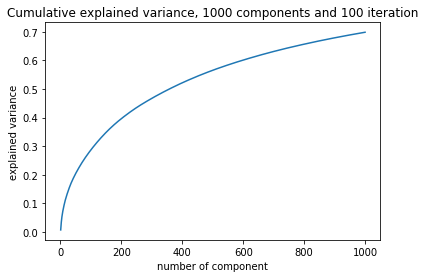

In [237]:
"""
trying different number of components and iteration in order to find numbers of components 
with at least 60% of the variance explained.
In this case we used 1000 component and 1000 iteration.
"""
plt.plot(list(range(1, 1001)), np.cumsum(svd_test.explained_variance_ratio_))
plt.title('Cumulative explained variance, 1000 components and 100 iteration')
plt.ylabel('explained variance')
plt.xlabel('number of component')
plt.show()

In [ ]:
"""
We decide to reduse the number of component to 800. 
As shown in the plot above, this number of features is related to a expleaned variance ratio equal to 65%
"""
svd = TruncatedSVD(n_components=800, n_iter=1000, random_state=42, algorithm= 'arpack')
svd.fit(response)

In [20]:
svd_data_reduct = svd.transform(response)

# Elbow method to find the optimal value of K 
We measured the inertia for 11 different number of clusters. We decided to evaluate the goodness of the clusters for low values of the number of clusters due to the computational time.

In [ ]:
elbow = {}
for k in range (2, 13):
    model = KMeans(k, init='k-means++')
    model.fit(trasformed)
    model.predict(trasformed)
    elbow[k]= model.inertia_

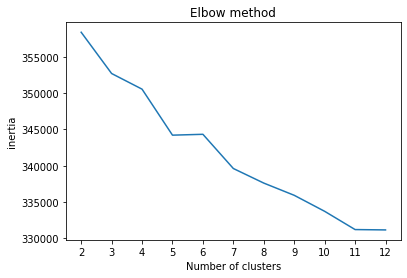

In [240]:
plt.plot(list(elbow.keys()), [elbow[k] for k in elbow.keys()])
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.show()

The plot above shown an almost constant inertia decreasing. Having no good results form the elbow plot, we decided to pick 5 as the number of cluster over to perform our next analysis

# World Cloud
In this section we analys the most frequent worlds in clusters for both the algorithm: k-mean++ and the k-mean implamented from scratch. 
In 4 clusters over 5, both the algorithms catched the same topit: animal food, tea, coffe, and an undefined product category. The 5th cluster is different. The k-mean from scratch catch a group of review about energy drink product. Instead the k-mean++ algorithm selected a group of review about chips and salt snack.
Both, the randomness of the 5th cluster and the anonymous product cluster are symptoms that the number of cluster chosen is too low.

In [ ]:
#k-means ++
model = KMeans(5, init='k-means++')
model.fit(svd_data_reduct)
clusters = model.predict(svd_data_reduct)

In [194]:
#k.means from scratch
centroid, class_ = K_Means(svd_data_reduct, 5)

0.6558823269714579
0.1113351141397172
0.051138952437423946
0.018563127878370344
0.01692584853436295
0.013454030242046527
0.014824303964342095
0.024144419771827137
0.02401822962579829
0.0059397527713246825
0.00264398332943829
0.0012198933347812198
0.0010542685966728818
0.0008361595522003758


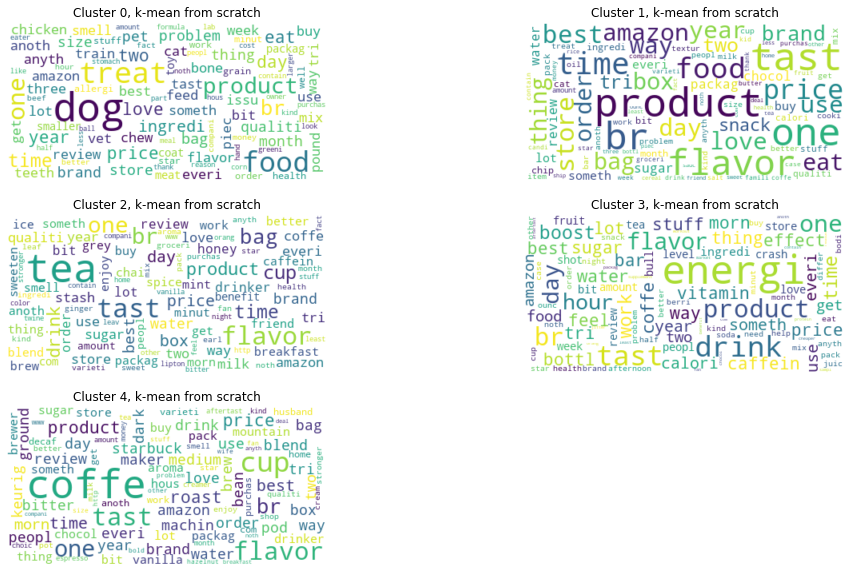

In [204]:
plt.figure(figsize=(17,10))
for i, k in enumerate(set(class_)):
    plt.subplot(3, 2, i+1)
    idx = np.where(class_ == k)
    words = tfidf.inverse_transform(response[idx])
    List = np.concatenate(words, axis = 0 ).tolist()
    frequency = pd.Series(List).value_counts()

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequency)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster ' + str(k)+', k-mean from scratch')

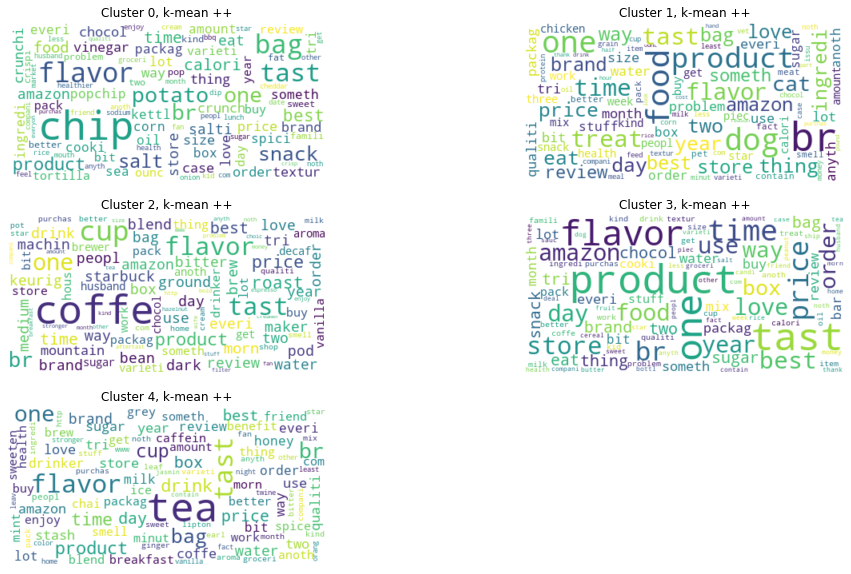

In [205]:
plt.figure(figsize=(17,10))
for i, k in enumerate(set(clusters)):
    plt.subplot(3, 2, i+1)
    idx = np.where(clusters == k)
    words = tfidf.inverse_transform(response[idx])
    List = np.concatenate(words, axis = 0 ).tolist()
    frequency = pd.Series(List).value_counts()

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(frequency)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster ' + str(k)+', k-mean ++')

# Provide the number of product in each cluster
In this section we studied the number of unique product belonging to each clusters. We perform our analysis over the results of both the algorithms: k-mean++ and k-mean from scratch.

In [102]:
# Unique product count for k-mean++ clusters
Unique_product = {}
for k in set(clusters):
    idx = np.where(clusters == k)
    Unique_product[k] = df_clean.ProductId.iloc[idx].nunique()

In [212]:
#unique product count for k-mean from scratch clusters
Unique_product_1 = {}
for k in set(class_):
    idx = np.where(class_ == k)
    Unique_product_1[k] = df_clean.ProductId.iloc[idx].nunique()

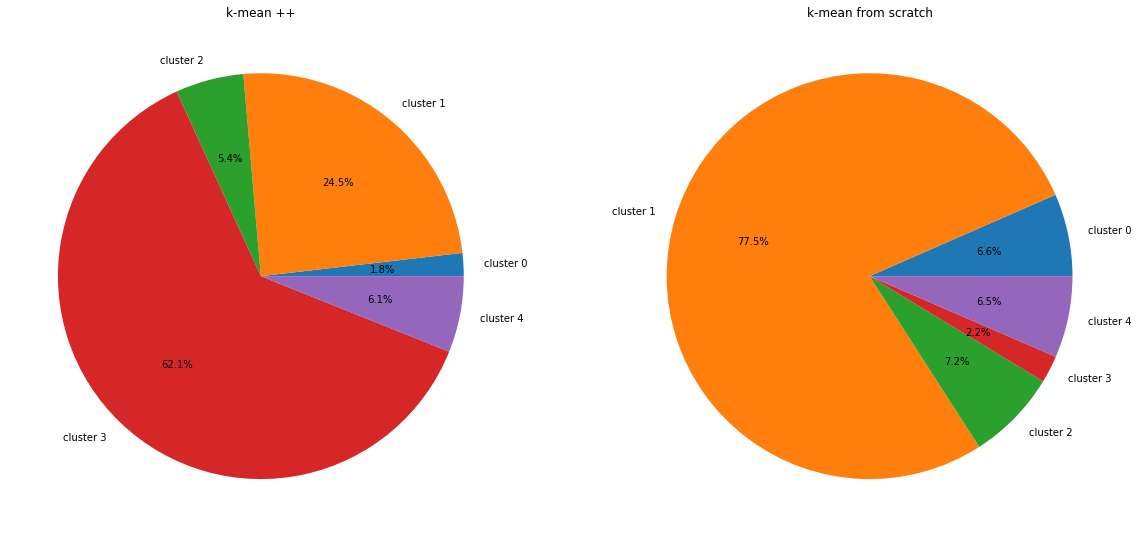

In [220]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.pie(Unique_product.values(), labels=['cluster '+str(k) for k in Unique_product.keys()],autopct='%1.1f%%')
plt.title('k-mean ++')

plt.subplot(1, 2, 2)
plt.pie(Unique_product_1.values(), labels=['cluster '+str(k) for k in Unique_product_1.keys()],autopct='%1.1f%%')
plt.title('k-mean from scratch')
plt.show()

As we can see, both the algorithms return a cluster grouping a lot of heterogeneous product. This means that we could increase the number of clusters to get better results.

# Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!
We studied the distribution of the reviews score over the clusters obtained with both the algorithms. The results are similar between clusters of the same algorithms and clusters of differnt algorithms. As shown below the mean scores are not statistically different from one cluster to another. This means that the in the whole dataset frequently users review the products with maximum score.

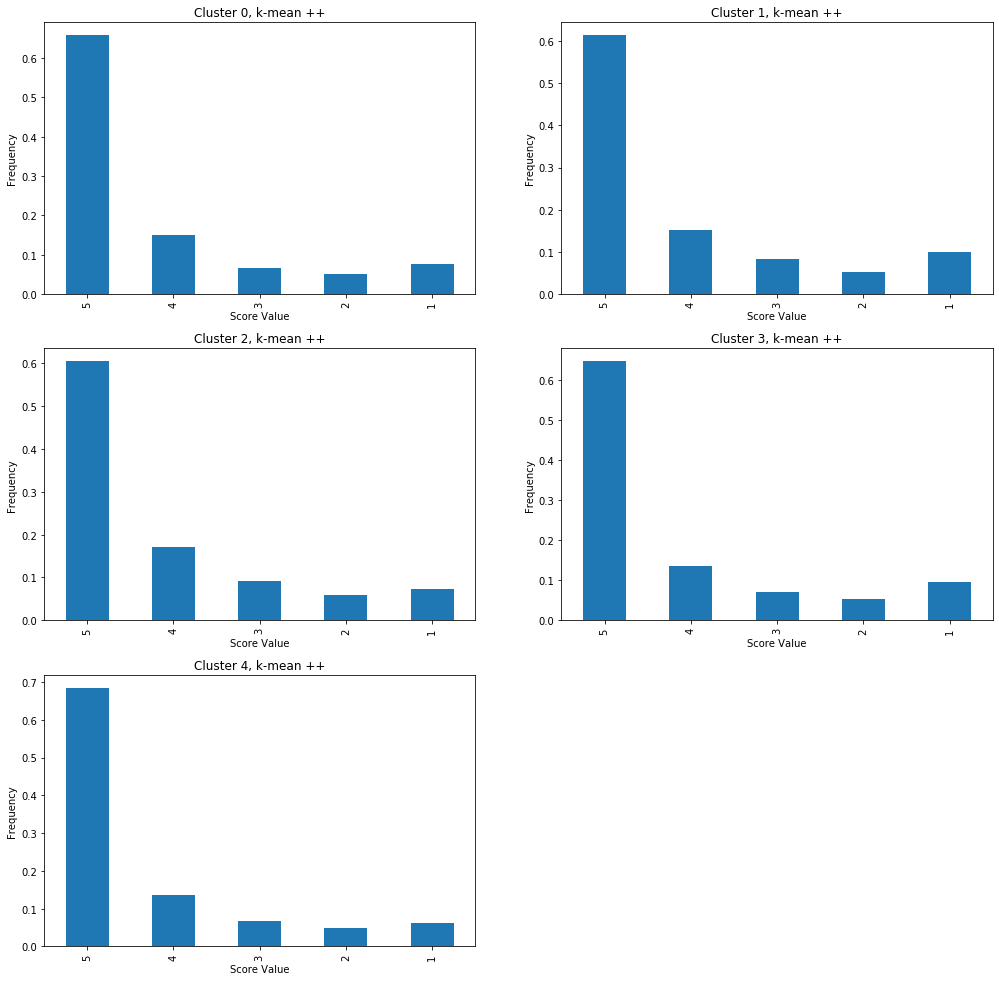

In [225]:
plt.figure(figsize=(17,17))
for i, k in enumerate(set(clusters)):
    idx = np.where(clusters == k)
    scores = df_clean[['Score']].iloc[idx].Score.value_counts()
    scores = scores.sort_values()
    plt.subplot(3, 2, i+1)
    (scores[[5, 4, 3, 2, 1]]/scores.sum()).plot.bar()
    plt.title('Cluster '+str(k) +', k-mean ++')
    plt.xlabel('Score Value')
    plt.ylabel('Frequency')

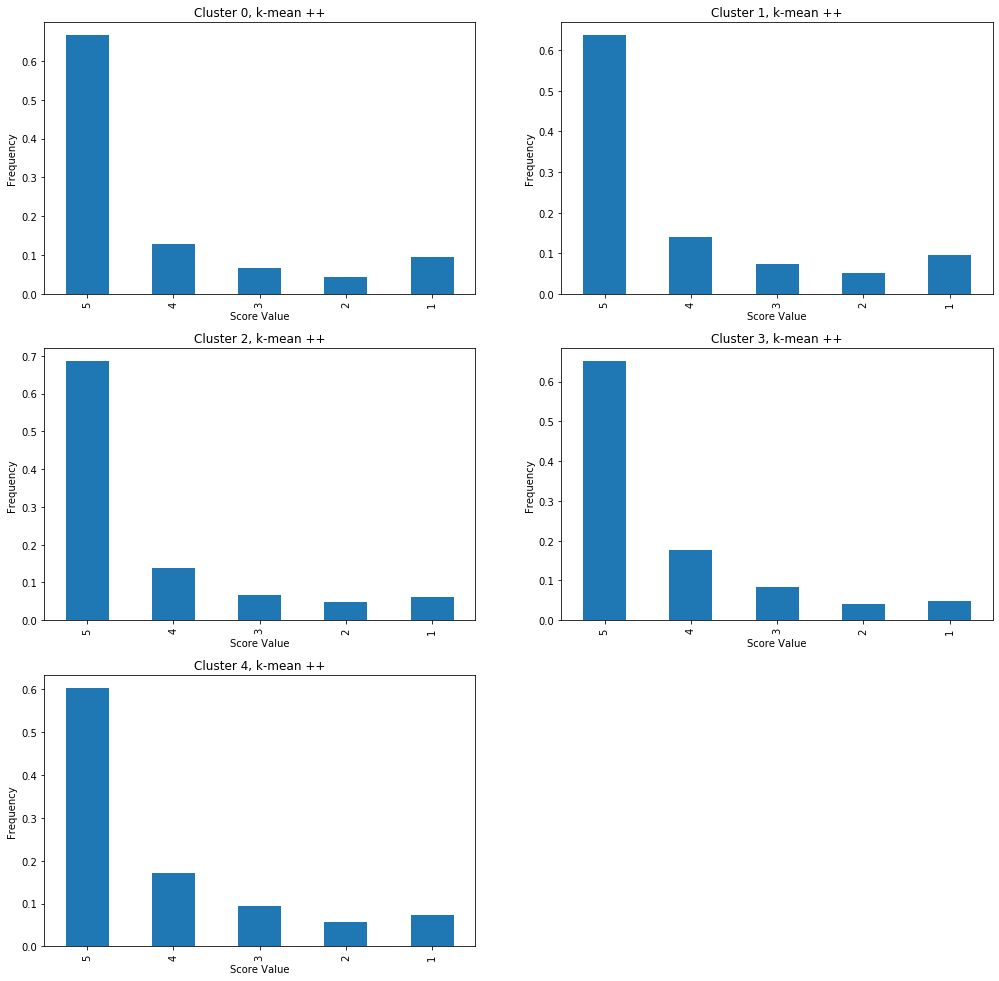

In [226]:
plt.figure(figsize=(17,17))
for i, k in enumerate(set(class_)):
    idx = np.where(class_ == k)
    scores = df_clean[['Score']].iloc[idx].Score.value_counts()
    scores = scores.sort_values()
    plt.subplot(3, 2, i+1)
    (scores[[5, 4, 3, 2, 1]]/scores.sum()).plot.bar()
    plt.title('Cluster '+str(k) +', k-mean ++')
    plt.xlabel('Score Value')
    plt.ylabel('Frequency')

In [227]:
# k-mean ++
for k in set(clusters):
    idx = np.where(clusters == k)
    scores = df_clean[['Score']].iloc[idx].Score.values
    mean_cluster = np.mean(scores)
    standard_dev = np.std(scores)
    
    print('Cluster_' + str(k)+ '  ', 'mean: ' , mean_cluster, '  standard deviation: ', standard_dev)

Cluster_0   mean:  4.263466117510779   standard deviation:  1.2404826486298128
Cluster_1   mean:  4.124984056904586   standard deviation:  1.3387265028706483
Cluster_2   mean:  4.179107070473102   standard deviation:  1.244045523849387
Cluster_3   mean:  4.181990161653546   standard deviation:  1.3250091878195278
Cluster_4   mean:  4.334095399379057   standard deviation:  1.182098011440792


In [228]:
# k-mean from scratch
for k in set(class_):
    idx = np.where(class_ == k)
    scores = df_clean[['Score']].iloc[idx].Score.values
    mean_cluster = np.mean(scores)
    standard_dev = np.std(scores)
    
    print('Cluster_' + str(k)+ '  ', 'mean: ' , mean_cluster, '  standard deviation: ', standard_dev)

Cluster_0   mean:  4.228891377379619   standard deviation:  1.304967558505223
Cluster_1   mean:  4.16494212962963   standard deviation:  1.3303908926351595
Cluster_2   mean:  4.334187257251467   standard deviation:  1.180949054226394
Cluster_3   mean:  4.341459721380981   standard deviation:  1.101662221351189
Cluster_4   mean:  4.174429515087825   standard deviation:  1.2487621679017928


# Get the number of unique users writing reviews in each cluster
The same considerations as above, in the section about the number of products,could be applied in this one.

In [188]:
# k-mean ++
Unique_User = {}
for k in set(clusters):
    idx = np.where(clusters == k)
    Unique_User[k] = df_clean.UserId.iloc[idx].nunique()

In [230]:
# k-mean from scratch
Unique_User_1 = {}
for k in set(class_):
    idx = np.where(class_ == k)
    Unique_User_1[k] = df_clean.UserId.iloc[idx].nunique()

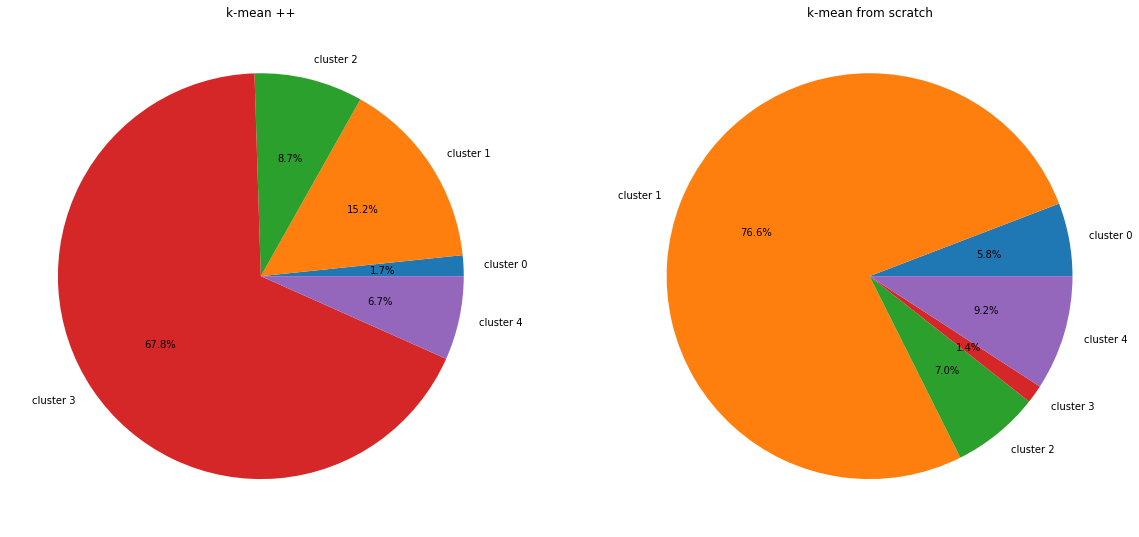

In [232]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.pie(Unique_User.values(), labels=['cluster '+str(k) for k in Unique_User.keys()],autopct='%1.1f%%')
plt.title('k-mean ++')

plt.subplot(1, 2, 2)
plt.pie(Unique_User_1.values(), labels=['cluster '+str(k) for k in Unique_User_1.keys()],autopct='%1.1f%%')
plt.title('k-mean from scratch')
plt.show()

# 3. Prove that we can sort a list in time O(n + r)

In [241]:
#n length of a list
#r is the length of second list

lst = [1,4,3,2,2,5,6,7,8,3,1,10,20]

def sorting(lst):
    max_ = max(lst)
    min_ = min(lst)
    b = max_-min_+1

    emp_lst = [0]*b

    for i in lst:
        emp_lst[i-min_] += 1

    i = 0
    for count in range(b): 
        while emp_lst[count] > 0: 
            emp_lst[count] -= 1
            lst[i] = count + min_ 
            i += 1
    return lst

sorting(lst)

#Code sorts list by iterating through the first list once and through the second list also once. 
#Which means that overall complexity is just O(n+r)

[1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 8, 10, 20]

The proof of the runtime complexity can be understood from the two loop for. The frist one depends on the leght of the given list and give a contribution of order O(n). The second loop has a contribution of order O(r), and this is due to the number of the keys in the list. So the worst case is of the order of O(n+r)